In [1]:
%load_ext watermark


In [2]:
import itertools as it
import os

from IPython.display import display
import itertools as it
import matplotlib.ticker as mpl_ticker
import outset as otst
import pandas as pd
import polars as pl
import seaborn as sns
from teeplot import teeplot as tp


In [3]:
%watermark -diwmuv -iv


Last updated: 2025-01-26T17:02:44.794106+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.5.0-1025-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

pandas    : 2.2.3
polars    : 1.9.0
matplotlib: 3.9.2
teeplot   : 1.2.0
seaborn   : 0.13.2
outset    : 0.1.9

Watermark: 2.4.3



In [4]:
teeplot_subdir = os.environ.get("NOTEBOOK_NAME", "2025-01-18-cpp-bench-speed")
teeplot_subdir


'2025-01-18-cpp-bench-speed'

## Prep Data


In [5]:
df = pl.concat(
    [
        pl.read_csv("https://osf.io/wb64p/download"),
        pl.read_csv("https://osf.io/mypjt/download"),
    ],
)
df = (
    df.cast(
        {
            "memory_bytes": pl.Int32,
            "num_items": pl.Int32,
            "num_sites": pl.Int32,
            "duration_s": pl.Float64,
            "replicate": pl.Int32,
        },
    )
    .with_columns(
        duration_per_item_ns=(
            pl.col("duration_s") * 1_000_000_000 / pl.col("num_items")
        )
    )
    .filter(pl.col("algo_name") != "naive_steady_algo")
    .with_columns(
        algo_name=pl.col("algo_name").replace(
            {"zhao_steady_algo": "naive_steady_algo"},
        ),
    )
    .with_columns(
        algorithm=pl.col("algo_name").map_elements(
            {
                "control_ring_algo": "\u200bcontrol: ringbuf",
                "control_throwaway_algo": "\u200bcontrol: discard",
                "dstream.steady_algo": "dstream steady",
                "dstream.stretched_algo": "dstream stretched",
                "dstream.tilted_algo": "dstream tilted",
                "naive_steady_algo": "naive steady",
                "zhao_tilted_algo": "naive tilted",
                # "zhao_steady_algo": "zhao steady",
            }.__getitem__,
            return_dtype=str,
        )
    )
    .with_columns(pl.col("data_type").alias("data type"))
)

display(df.describe()), display(df.head()), display(df.tail());


shape: (9, 12)
┌───────────┬───────────┬───────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ statistic ┆ algo_name ┆ data_type ┆ compiler ┆ … ┆ duration_ ┆ duration_ ┆ algorithm ┆ data type │
│ ---       ┆ ---       ┆ ---       ┆ ---      ┆   ┆ s         ┆ per_item_ ┆ ---       ┆ ---       │
│ str       ┆ str       ┆ str       ┆ str      ┆   ┆ ---       ┆ ns        ┆ str       ┆ str       │
│           ┆           ┆           ┆          ┆   ┆ f64       ┆ ---       ┆           ┆           │
│           ┆           ┆           ┆          ┆   ┆           ┆ f64       ┆           ┆           │
╞═══════════╪═══════════╪═══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ count     ┆ 16800     ┆ 16800     ┆ 16800    ┆ … ┆ 16800.0   ┆ 16800.0   ┆ 16800     ┆ 16800     │
│ null_coun ┆ 0         ┆ 0         ┆ 0        ┆ … ┆ 0.0       ┆ 0.0       ┆ 0         ┆ 0         │
│ t         ┆           ┆           ┆          ┆   ┆           ┆           ┆           ┆           │
│ mean      ┆ null      ┆ null      ┆ null     ┆ … ┆ 0.00391   ┆ 42.150447 ┆ null      ┆ null      │
│ std       ┆ null      ┆ null      ┆ null     ┆ … ┆ 0.013029  ┆ 257.89312 ┆ null      ┆ null      │
│           ┆           ┆           ┆          ┆   ┆           ┆ 6         ┆           ┆           │
│ min       ┆ control_r ┆ bit       ┆ clang++  ┆ … ┆ 0.000018  ┆ 1.82174   ┆ dstream   ┆ bit       │
│           ┆ ing_algo  ┆           ┆          ┆   ┆           ┆           ┆ steady    ┆           │
│ 25%       ┆ null      ┆ null      ┆ null     ┆ … ┆ 0.000084  ┆ 1.92845   ┆ null      ┆ null      │
│ 50%       ┆ null      ┆ null      ┆ null     ┆ … ┆ 0.000456  ┆ 3.716904  ┆ null      ┆ null      │
│ 75%       ┆ null      ┆ null      ┆ null     ┆ … ┆ 0.002454  ┆ 8.028292  ┆ null      ┆ null      │
│ max       ┆ zhao_tilt ┆ word      ┆ g++      ┆ … ┆ 0.212359  ┆ 4790.0664 ┆ ​control:  ┆ word      │
│           ┆ ed_algo   ┆           ┆          ┆   ┆           ┆           ┆ ringbuf   ┆           │
└───────────┴───────────┴───────────┴──────────┴───┴───────────┴───────────┴───────────┴───────────┘

shape: (5, 11)
┌───────────┬───────────┬──────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ algo_name ┆ data_type ┆ compiler ┆ memory_by ┆ … ┆ duration_ ┆ duration_ ┆ algorithm ┆ data type │
│ ---       ┆ ---       ┆ ---      ┆ tes       ┆   ┆ s         ┆ per_item_ ┆ ---       ┆ ---       │
│ str       ┆ str       ┆ str      ┆ ---       ┆   ┆ ---       ┆ ns        ┆ str       ┆ str       │
│           ┆           ┆          ┆ i32       ┆   ┆ f64       ┆ ---       ┆           ┆           │
│           ┆           ┆          ┆           ┆   ┆           ┆ f64       ┆           ┆           │
╞═══════════╪═══════════╪══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ control_r ┆ bit       ┆ g++      ┆ 12        ┆ … ┆ 0.000019  ┆ 1.9226    ┆ ​control:  ┆ bit       │
│ ing_algo  ┆           ┆          ┆           ┆   ┆           ┆           ┆ ringbuf   ┆           │
│ control_r ┆ bit       ┆ g++      ┆ 12        ┆ … ┆ 0.000025  ┆ 2.5088    ┆ ​control:  ┆ bit       │
│ ing_algo  ┆           ┆          ┆           ┆   ┆           ┆           ┆ ringbuf   ┆           │
│ control_r ┆ bit       ┆ g++      ┆ 12        ┆ … ┆ 0.000019  ┆ 1.9127    ┆ ​control:  ┆ bit       │
│ ing_algo  ┆           ┆          ┆           ┆   ┆           ┆           ┆ ringbuf   ┆           │
│ control_r ┆ bit       ┆ g++      ┆ 12        ┆ … ┆ 0.000019  ┆ 1.9126    ┆ ​control:  ┆ bit       │
│ ing_algo  ┆           ┆          ┆           ┆   ┆           ┆           ┆ ringbuf   ┆           │
│ control_r ┆ bit       ┆ g++      ┆ 12        ┆ … ┆ 0.000019  ┆ 1.9127    ┆ ​control:  ┆ bit       │
│ ing_algo  ┆           ┆          ┆           ┆   ┆           ┆           ┆ ringbuf   ┆           │
└───────────┴───────────┴──────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

shape: (5, 11)
┌───────────┬───────────┬──────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ algo_name ┆ data_type ┆ compiler ┆ memory_by ┆ … ┆ duration_ ┆ duration_ ┆ algorithm ┆ data type │
│ ---       ┆ ---       ┆ ---      ┆ tes       ┆   ┆ s         ┆ per_item_ ┆ ---       ┆ ---       │
│ str       ┆ str       ┆ str      ┆ ---       ┆   ┆ ---       ┆ ns        ┆ str       ┆ str       │
│           ┆           ┆          ┆ i32       ┆   ┆ f64       ┆ ---       ┆           ┆           │
│           ┆           ┆          ┆           ┆   ┆           ┆ f64       ┆           ┆           │
╞═══════════╪═══════════╪══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ zhao_tilt ┆ quad word ┆ clang++  ┆ 276       ┆ … ┆ 0.008233  ┆ 8.233     ┆ naive     ┆ quad word │
│ ed_algo   ┆           ┆          ┆           ┆   ┆           ┆           ┆ tilted    ┆           │
│ zhao_tilt ┆ quad word ┆ clang++  ┆ 276       ┆ … ┆ 0.008049  ┆ 8.048921  ┆ naive     ┆ quad word │
│ ed_algo   ┆           ┆          ┆           ┆   ┆           ┆           ┆ tilted    ┆           │
│ zhao_tilt ┆ quad word ┆ clang++  ┆ 276       ┆ … ┆ 0.008076  ┆ 8.075852  ┆ naive     ┆ quad word │
│ ed_algo   ┆           ┆          ┆           ┆   ┆           ┆           ┆ tilted    ┆           │
│ zhao_tilt ┆ quad word ┆ clang++  ┆ 276       ┆ … ┆ 0.008076  ┆ 8.075692  ┆ naive     ┆ quad word │
│ ed_algo   ┆           ┆          ┆           ┆   ┆           ┆           ┆ tilted    ┆           │
│ zhao_tilt ┆ quad word ┆ clang++  ┆ 276       ┆ … ┆ 0.008085  ┆ 8.084859  ┆ naive     ┆ quad word │
│ ed_algo   ┆           ┆          ┆           ┆   ┆           ┆           ┆ tilted    ┆           │
└───────────┴───────────┴──────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

## Plot


data_type=('byte',)


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:225: UserWarning: 
The markers list has fewer values (2) than needed (7) and will cycle, which may produce an uninterpretable plot.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-01-18-cpp-bench-speed/col=compiler+data_type=('byte',)+hue=algo-name+kind=line+palette=muted+style=algo-name+viz=relplot+x=num-sites+y=duration-s+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/col=compiler+data_type=('byte',)+hue=algo-name+kind=line+palette=muted+style=algo-name+viz=relplot+x=num-sites+y=duration-s+ext=.png


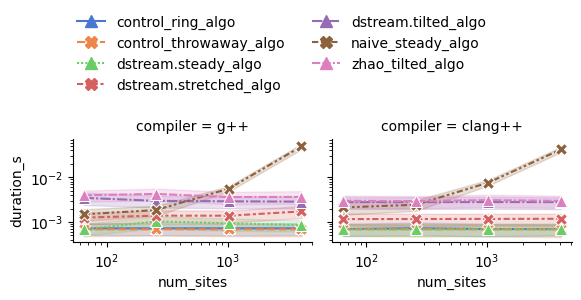

data_type=('quad word',)


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:225: UserWarning: 
The markers list has fewer values (2) than needed (7) and will cycle, which may produce an uninterpretable plot.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-01-18-cpp-bench-speed/col=compiler+data_type=('quad word',)+hue=algo-name+kind=line+palette=muted+style=algo-name+viz=relplot+x=num-sites+y=duration-s+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/col=compiler+data_type=('quad word',)+hue=algo-name+kind=line+palette=muted+style=algo-name+viz=relplot+x=num-sites+y=duration-s+ext=.png


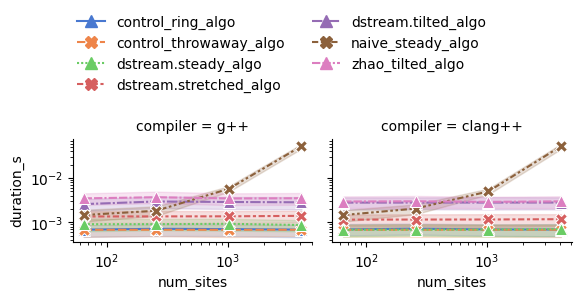

data_type=('bit',)


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:225: UserWarning: 
The markers list has fewer values (2) than needed (7) and will cycle, which may produce an uninterpretable plot.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-01-18-cpp-bench-speed/col=compiler+data_type=('bit',)+hue=algo-name+kind=line+palette=muted+style=algo-name+viz=relplot+x=num-sites+y=duration-s+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/col=compiler+data_type=('bit',)+hue=algo-name+kind=line+palette=muted+style=algo-name+viz=relplot+x=num-sites+y=duration-s+ext=.png


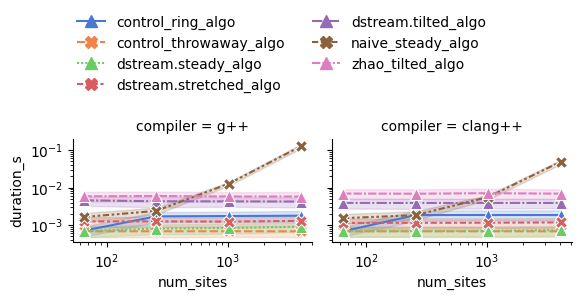

data_type=('double word',)


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:225: UserWarning: 
The markers list has fewer values (2) than needed (7) and will cycle, which may produce an uninterpretable plot.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-01-18-cpp-bench-speed/col=compiler+data_type=('double word',)+hue=algo-name+kind=line+palette=muted+style=algo-name+viz=relplot+x=num-sites+y=duration-s+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/col=compiler+data_type=('double word',)+hue=algo-name+kind=line+palette=muted+style=algo-name+viz=relplot+x=num-sites+y=duration-s+ext=.png


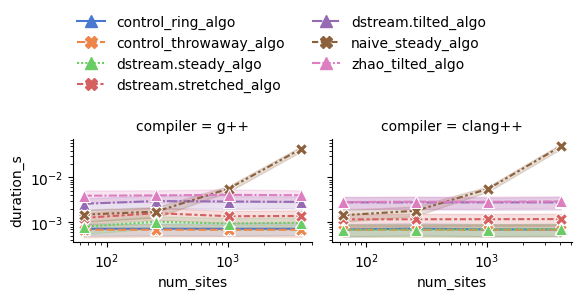

data_type=('word',)


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:225: UserWarning: 
The markers list has fewer values (2) than needed (7) and will cycle, which may produce an uninterpretable plot.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-01-18-cpp-bench-speed/col=compiler+data_type=('word',)+hue=algo-name+kind=line+palette=muted+style=algo-name+viz=relplot+x=num-sites+y=duration-s+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/col=compiler+data_type=('word',)+hue=algo-name+kind=line+palette=muted+style=algo-name+viz=relplot+x=num-sites+y=duration-s+ext=.png


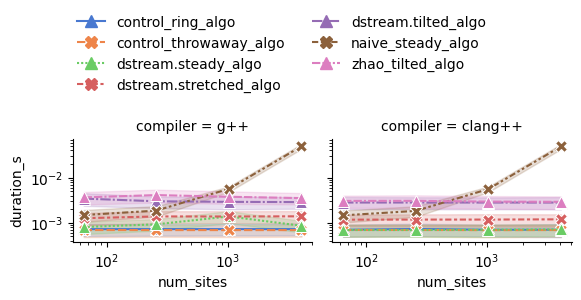

In [6]:
for data_type, data in df.group_by("data type"):
    print(f"{data_type=}")
    with tp.teed(
        sns.relplot,
        data=data,
        x="num_sites",
        y="duration_s",
        col="compiler",
        hue="algo_name",
        style="algo_name",
        palette="muted",
        kind="line",
        aspect=1.5,
        markers=["^", "X"],
        ms=8,
        height=2,
        teeplot_subdir=teeplot_subdir,
        teeplot_outattrs={"data_type": data_type},
    ) as g:
        g.set(xscale="log", yscale="log")
        sns.move_legend(
            g,
            "lower center",
            bbox_to_anchor=(0.35, 1),
            ncol=2,
            title=None,
            frameon=False,
        )
        g.tight_layout()


data_type=('byte',)


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:225: UserWarning: 
The markers list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-01-18-cpp-bench-speed/col=algorithm+data_type=('byte',)+hue=buffer-capacity+kind=line+palette=muted+row=compiler+style=buffer-capacity+viz=relplot+x=num-items+y=duration-s+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/col=algorithm+data_type=('byte',)+hue=buffer-capacity+kind=line+palette=muted+row=compiler+style=buffer-capacity+viz=relplot+x=num-items+y=duration-s+ext=.png


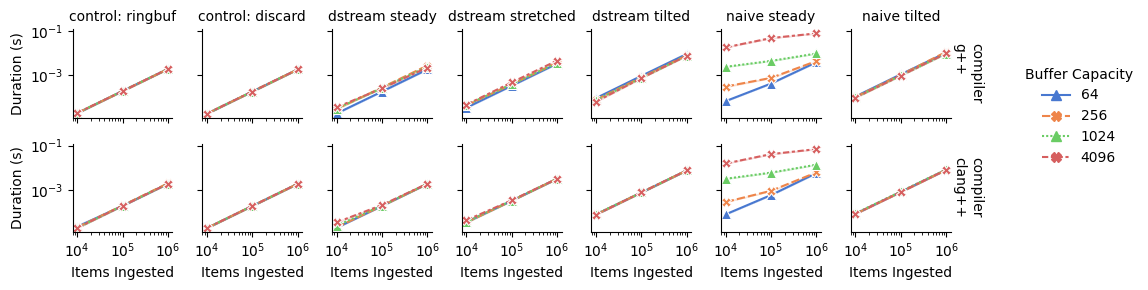

data_type=('bit',)


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:225: UserWarning: 
The markers list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-01-18-cpp-bench-speed/col=algorithm+data_type=('bit',)+hue=buffer-capacity+kind=line+palette=muted+row=compiler+style=buffer-capacity+viz=relplot+x=num-items+y=duration-s+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/col=algorithm+data_type=('bit',)+hue=buffer-capacity+kind=line+palette=muted+row=compiler+style=buffer-capacity+viz=relplot+x=num-items+y=duration-s+ext=.png


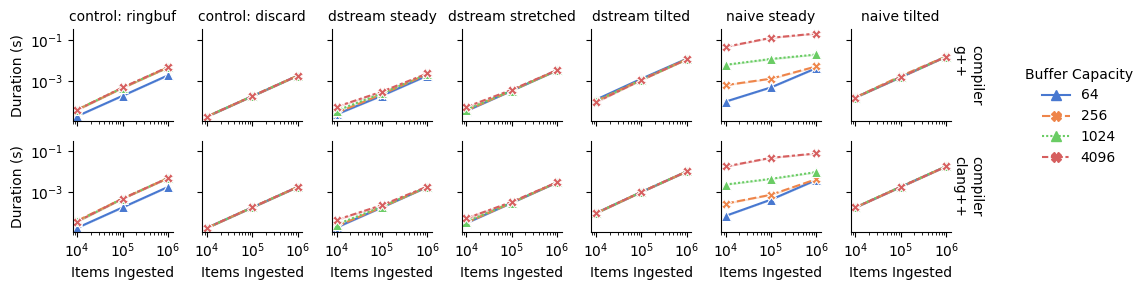

data_type=('double word',)


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:225: UserWarning: 
The markers list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-01-18-cpp-bench-speed/col=algorithm+data_type=('double word',)+hue=buffer-capacity+kind=line+palette=muted+row=compiler+style=buffer-capacity+viz=relplot+x=num-items+y=duration-s+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/col=algorithm+data_type=('double word',)+hue=buffer-capacity+kind=line+palette=muted+row=compiler+style=buffer-capacity+viz=relplot+x=num-items+y=duration-s+ext=.png


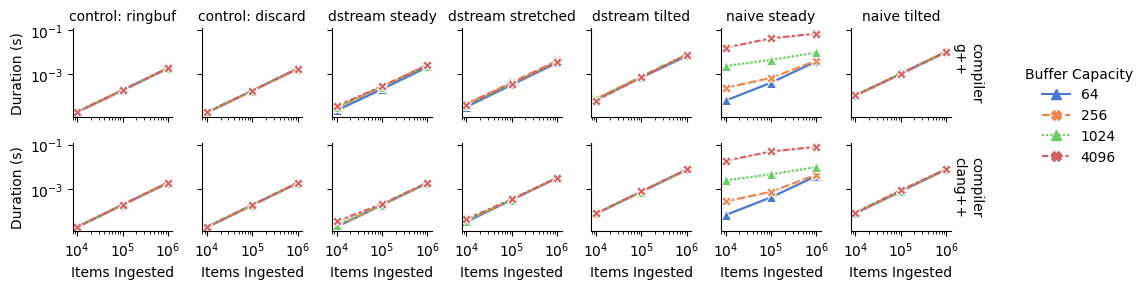

data_type=('word',)


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:225: UserWarning: 
The markers list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-01-18-cpp-bench-speed/col=algorithm+data_type=('word',)+hue=buffer-capacity+kind=line+palette=muted+row=compiler+style=buffer-capacity+viz=relplot+x=num-items+y=duration-s+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/col=algorithm+data_type=('word',)+hue=buffer-capacity+kind=line+palette=muted+row=compiler+style=buffer-capacity+viz=relplot+x=num-items+y=duration-s+ext=.png


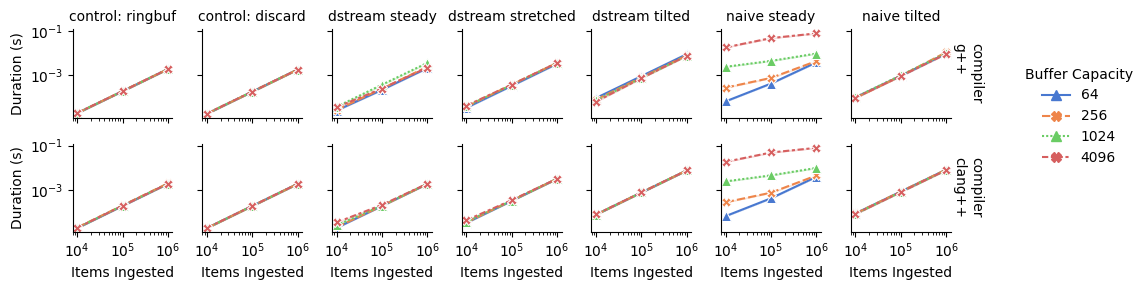

data_type=('quad word',)


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:225: UserWarning: 
The markers list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-01-18-cpp-bench-speed/col=algorithm+data_type=('quad word',)+hue=buffer-capacity+kind=line+palette=muted+row=compiler+style=buffer-capacity+viz=relplot+x=num-items+y=duration-s+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/col=algorithm+data_type=('quad word',)+hue=buffer-capacity+kind=line+palette=muted+row=compiler+style=buffer-capacity+viz=relplot+x=num-items+y=duration-s+ext=.png


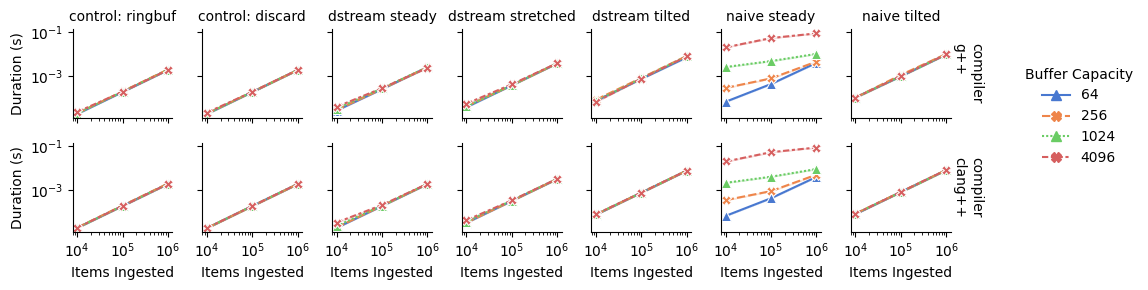

In [7]:
for data_type, data in df.group_by("data type"):
    print(f"{data_type=}")
    with tp.teed(
        sns.relplot,
        data=data.with_columns(
            pl.col("num_sites").alias("Buffer Capacity"),
        ),
        x="num_items",
        y="duration_s",
        col="algorithm",
        row="compiler",
        hue="Buffer Capacity",
        style="Buffer Capacity",
        facet_kws=dict(margin_titles=True),
        palette="muted",
        kind="line",
        aspect=1,
        markers=["^", "X"],
        ms=7,
        height=1.5,
        teeplot_outattrs={"data_type": data_type},
        teeplot_subdir=teeplot_subdir,
    ) as g:
        g.set(xscale="log", yscale="log")
        g.set_titles(
            col_template="{col_name}",
            row_template="{row_var}\n{row_name}",
        )
        g.set_xlabels("Items Ingested")
        g.set_ylabels("Duration (s)")
        sns.move_legend(
            g,
            "upper left",
            bbox_to_anchor=(0.87, 0.8),
            ncol=1,
            title="Buffer Capacity",
            frameon=False,
        )
        g.tight_layout()


compiler='clang++', exclude='dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo'


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:225: UserWarning: 
The markers list has fewer values (1) than needed (5) and will cycle, which may produce an uninterpretable plot.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


teeplots/2025-01-18-cpp-bench-speed/col=algorithm+compiler=compiler+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+hue=data-type+kind=line+markers=+palette=muted+row=buffer-capacity+style=data-type+viz=relplot+x=num.../-items+y=duration-s+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/col=algorithm+compiler=compiler+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+hue=data-type+kind=line+markers=+palette=muted+row=buffer-capacity+style=data-type+viz=relplot+x=num.../-items+y=duration-s+ext=.png


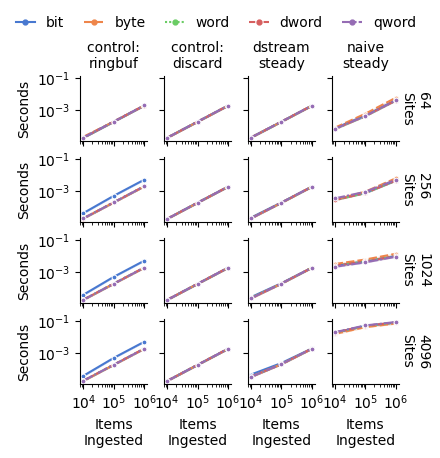

compiler='clang++', exclude=''


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:225: UserWarning: 
The markers list has fewer values (1) than needed (5) and will cycle, which may produce an uninterpretable plot.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


teeplots/2025-01-18-cpp-bench-speed/col=algorithm+compiler=compiler+exclude=+hue=data-type+kind=line+markers=+palette=muted+row=buffer-capacity+style=data-type+viz=relplot+x=num-items+y=duration-s+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/col=algorithm+compiler=compiler+exclude=+hue=data-type+kind=line+markers=+palette=muted+row=buffer-capacity+style=data-type+viz=relplot+x=num-items+y=duration-s+ext=.png


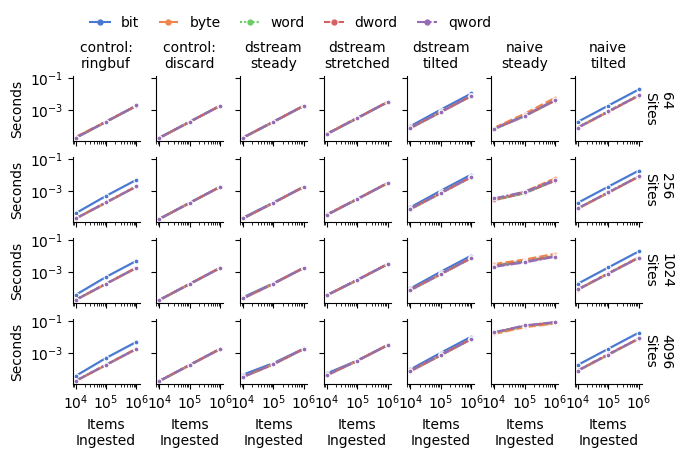

compiler='g++', exclude='dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo'


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:225: UserWarning: 
The markers list has fewer values (1) than needed (5) and will cycle, which may produce an uninterpretable plot.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: te

teeplots/2025-01-18-cpp-bench-speed/col=algorithm+compiler=compiler+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+hue=data-type+kind=line+markers=+palette=muted+row=buffer-capacity+style=data-type+viz=relplot+x=num.../-items+y=duration-s+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/col=algorithm+compiler=compiler+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+hue=data-type+kind=line+markers=+palette=muted+row=buffer-capacity+style=data-type+viz=relplot+x=num.../-items+y=duration-s+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/col=algorithm+compiler=compiler+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+hue=data-type+kind=line+markers=+palette=muted+row=buffer-capacity+style=data-type+viz=relplot+x=num.../-items+y=duration-s+ext=.png


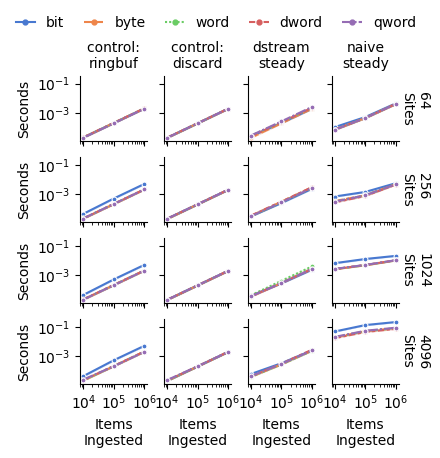

compiler='g++', exclude=''


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:225: UserWarning: 
The markers list has fewer values (1) than needed (5) and will cycle, which may produce an uninterpretable plot.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: te

teeplots/2025-01-18-cpp-bench-speed/col=algorithm+compiler=compiler+exclude=+hue=data-type+kind=line+markers=+palette=muted+row=buffer-capacity+style=data-type+viz=relplot+x=num-items+y=duration-s+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/col=algorithm+compiler=compiler+exclude=+hue=data-type+kind=line+markers=+palette=muted+row=buffer-capacity+style=data-type+viz=relplot+x=num-items+y=duration-s+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/col=algorithm+compiler=compiler+exclude=+hue=data-type+kind=line+markers=+palette=muted+row=buffer-capacity+style=data-type+viz=relplot+x=num-items+y=duration-s+ext=.png


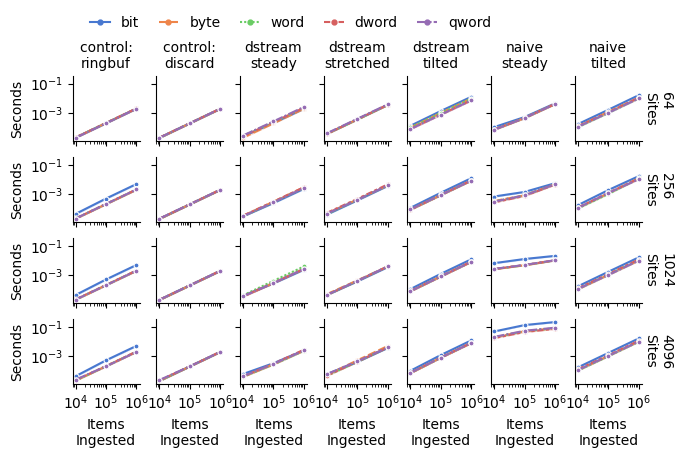

In [8]:
for compiler, exclude in it.product(
    df["compiler"].unique(),
    ("dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo", ""),
):
    print(f"{compiler=}, {exclude=}")
    data = (
        df
        .filter(~pl.col("algo_name").is_in(exclude.split(",")))
        .filter(pl.col("compiler") == compiler)
        .with_columns(
            pl.col("num_sites").alias("Buffer Capacity"),
            pl.col("algorithm").str.replace_all(" ", "\n"),
            pl.col("data type").str.replace_all("double word", "dword").str.replace_all("quad word", "qword"),
        )
    )
    with tp.teed(
        sns.relplot,
        data=data,
        x="num_items",
        y="duration_s",
        col="algorithm",
        row="Buffer Capacity",
        hue="data type",
        hue_order=["bit", "byte", "word", "dword", "qword"],
        style="data type",
        facet_kws=dict(
            margin_titles=True,
            sharey=True,
            gridspec_kws={"wspace": 0.25, "hspace": 0.25},
        ),
        palette="muted",
        kind="line",
        aspect=1,
        # markers=["X", "^", ".", "d", "s", "o"],
        markers=".",
        ms=7,
        height=1.0,
        teeplot_outattrs=dict(compiler="compiler", exclude=exclude),
        teeplot_subdir=teeplot_subdir,
    ) as g:
        g.set(xscale="log", yscale="log")
        g.set_titles(
            col_template="{col_name}",
            row_template="{row_name}\nSites",
        )
        g.set_xlabels("Items\nIngested")
        g.set_ylabels("Seconds")
        sns.move_legend(
            g, "lower center",
            bbox_to_anchor=(.4, 0.965), ncol=5, title=None, frameon=False,
            columnspacing=1.4,
            handlelength=1.4,
        )
        g.tight_layout()


compiler='g++', data_type='bit', num_items=10000, exclude=''


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4730/375946612.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)


teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


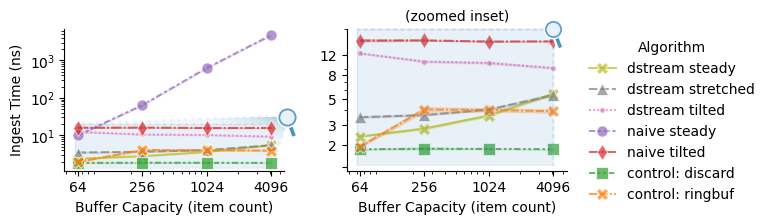

compiler='g++', data_type='bit', num_items=10000, exclude='dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo'


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4730/375946612.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)


teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


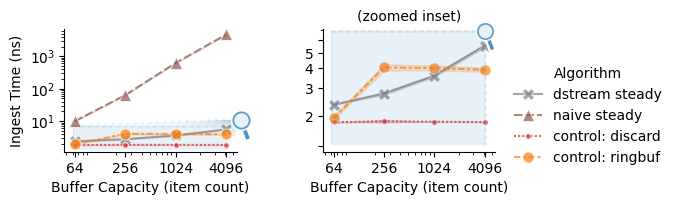

compiler='g++', data_type='bit', num_items=1000000, exclude=''


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4730/375946612.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)


teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


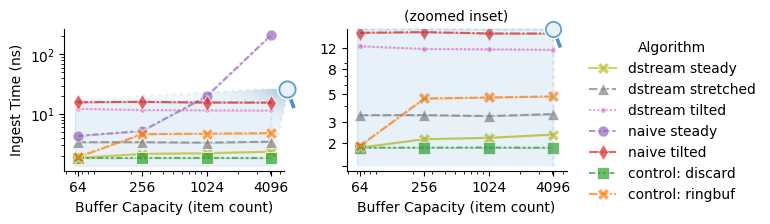

compiler='g++', data_type='bit', num_items=1000000, exclude='dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo'


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4730/375946612.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)


teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


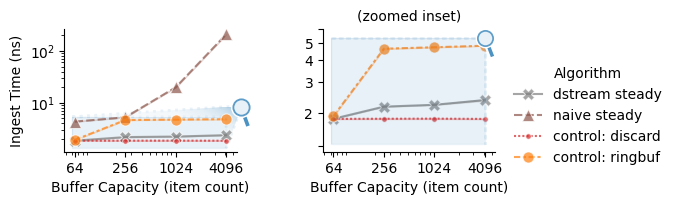

compiler='g++', data_type='quad word', num_items=10000, exclude=''


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4730/375946612.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


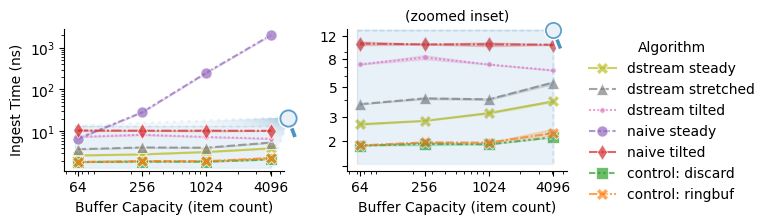

compiler='g++', data_type='quad word', num_items=10000, exclude='dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo'


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4730/375946612.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


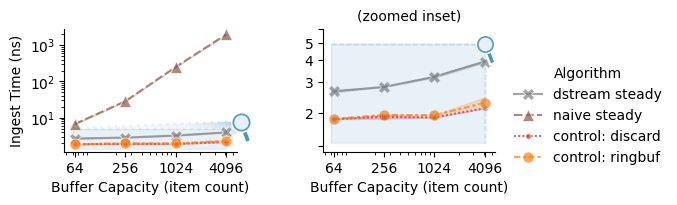

compiler='g++', data_type='quad word', num_items=1000000, exclude=''


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4730/375946612.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


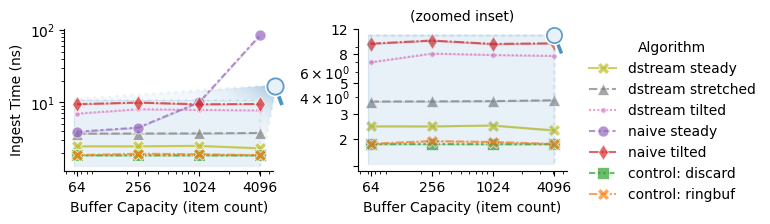

compiler='g++', data_type='quad word', num_items=1000000, exclude='dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo'


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4730/375946612.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


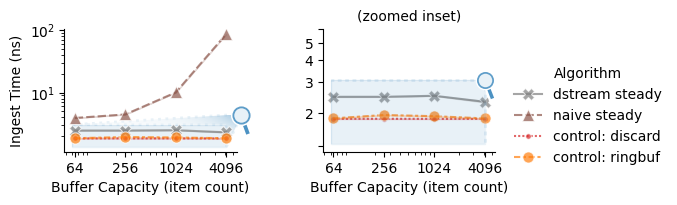

compiler='g++', data_type='byte', num_items=10000, exclude=''


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4730/375946612.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


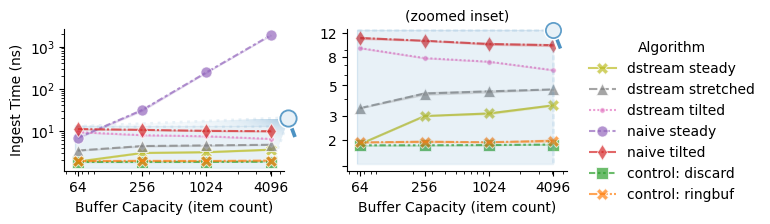

compiler='g++', data_type='byte', num_items=10000, exclude='dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo'


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4730/375946612.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


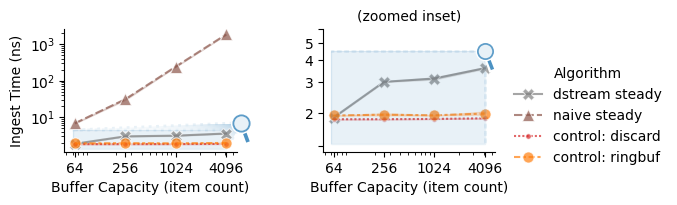

compiler='g++', data_type='byte', num_items=1000000, exclude=''


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4730/375946612.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


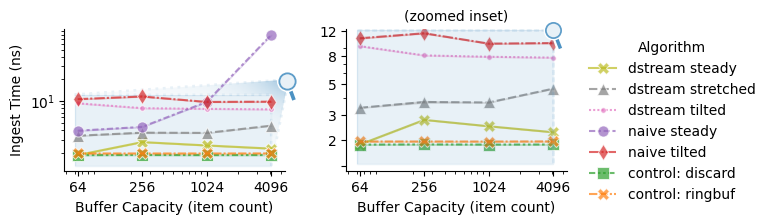

compiler='g++', data_type='byte', num_items=1000000, exclude='dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo'


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4730/375946612.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


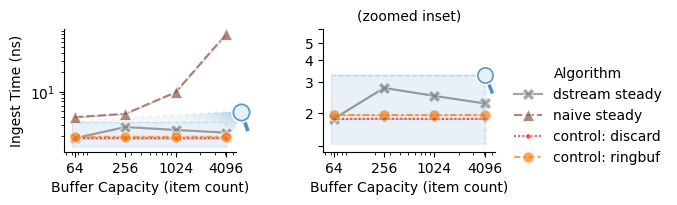

compiler='g++', data_type='double word', num_items=10000, exclude=''


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4730/375946612.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


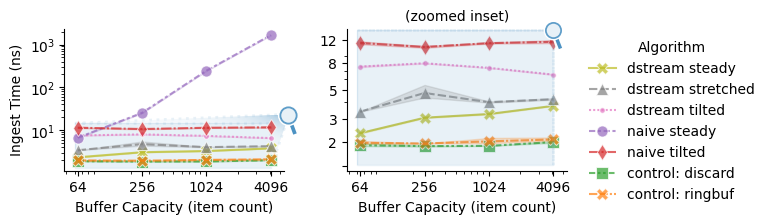

compiler='g++', data_type='double word', num_items=10000, exclude='dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo'


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4730/375946612.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


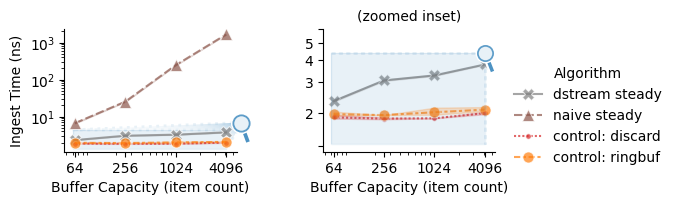

compiler='g++', data_type='double word', num_items=1000000, exclude=''


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4730/375946612.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


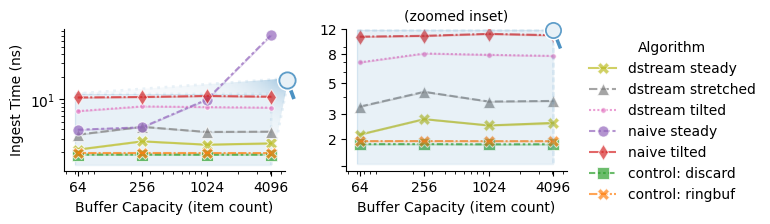

compiler='g++', data_type='double word', num_items=1000000, exclude='dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo'


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4730/375946612.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


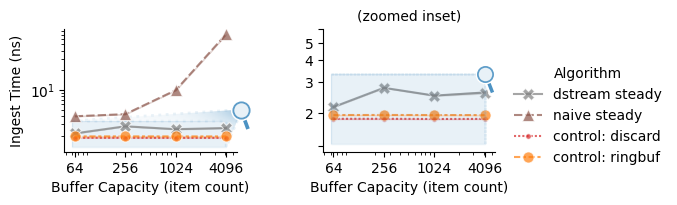

compiler='g++', data_type='word', num_items=10000, exclude=''


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4730/375946612.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


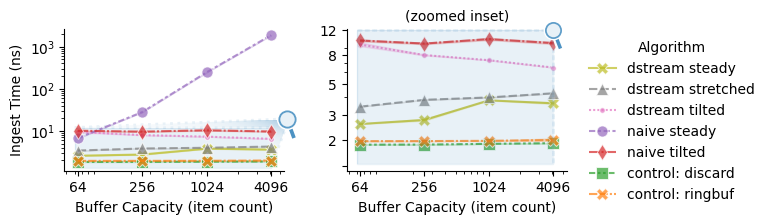

compiler='g++', data_type='word', num_items=10000, exclude='dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo'


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4730/375946612.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


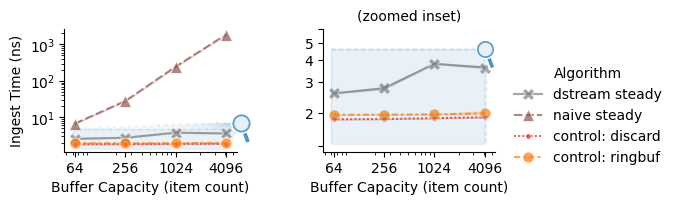

compiler='g++', data_type='word', num_items=1000000, exclude=''


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4730/375946612.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


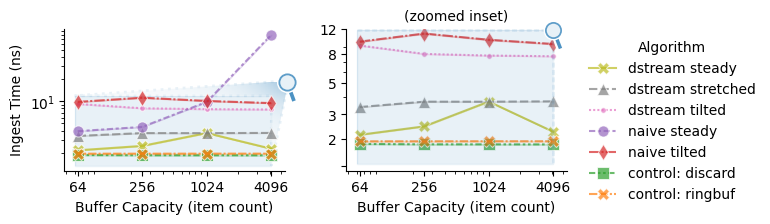

compiler='g++', data_type='word', num_items=1000000, exclude='dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo'


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4730/375946612.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


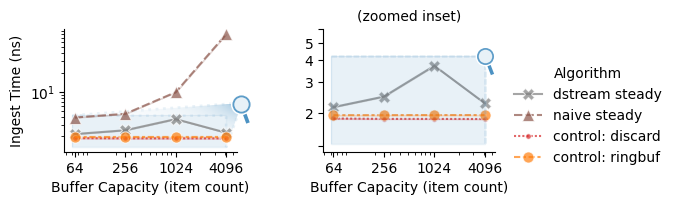

compiler='clang++', data_type='bit', num_items=10000, exclude=''


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4730/375946612.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)


teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


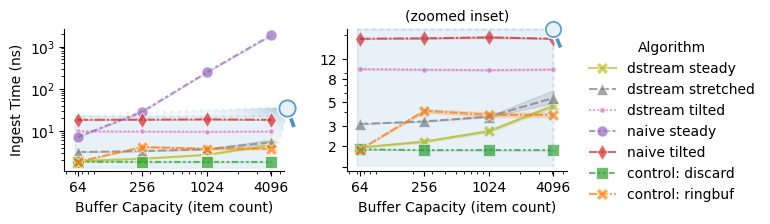

compiler='clang++', data_type='bit', num_items=10000, exclude='dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo'


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4730/375946612.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)


teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


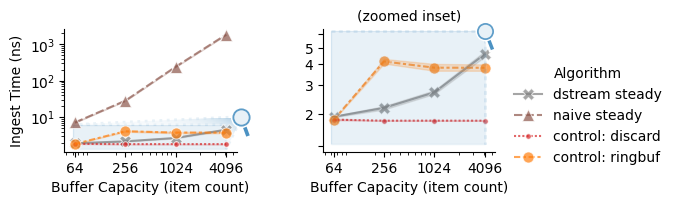

compiler='clang++', data_type='bit', num_items=1000000, exclude=''


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4730/375946612.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)


teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


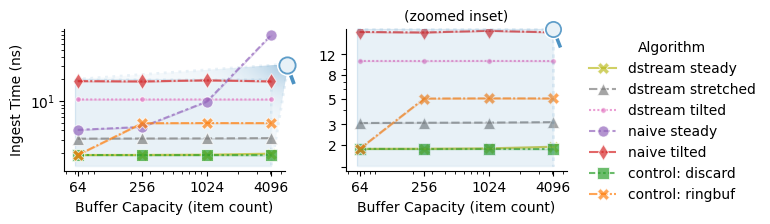

compiler='clang++', data_type='bit', num_items=1000000, exclude='dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo'


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4730/375946612.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)


teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


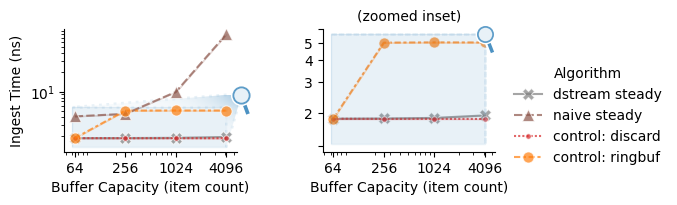

compiler='clang++', data_type='quad word', num_items=10000, exclude=''


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4730/375946612.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


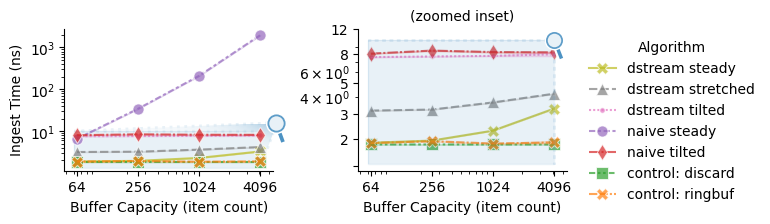

compiler='clang++', data_type='quad word', num_items=10000, exclude='dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo'


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4730/375946612.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


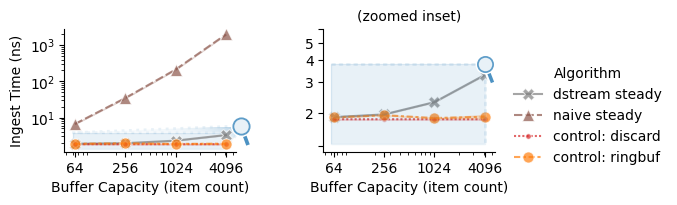

compiler='clang++', data_type='quad word', num_items=1000000, exclude=''


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4730/375946612.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


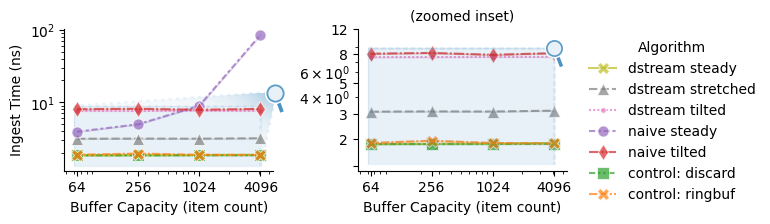

compiler='clang++', data_type='quad word', num_items=1000000, exclude='dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo'


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4730/375946612.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


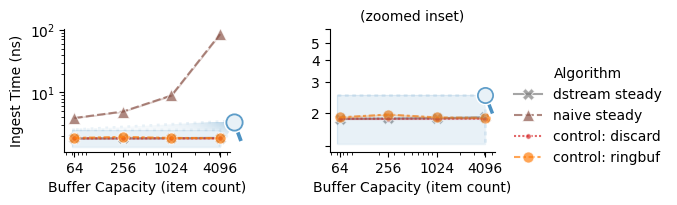

compiler='clang++', data_type='byte', num_items=10000, exclude=''


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4730/375946612.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


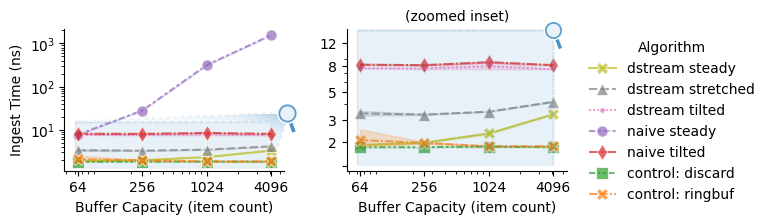

compiler='clang++', data_type='byte', num_items=10000, exclude='dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo'


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4730/375946612.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


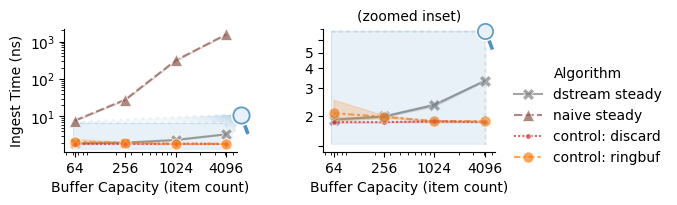

compiler='clang++', data_type='byte', num_items=1000000, exclude=''


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4730/375946612.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


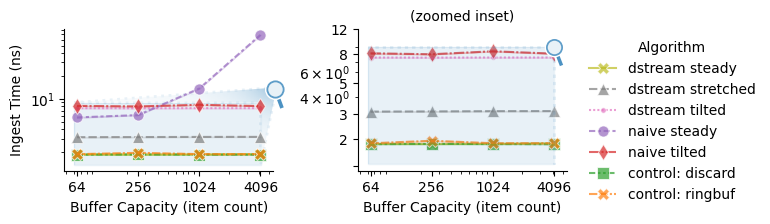

compiler='clang++', data_type='byte', num_items=1000000, exclude='dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo'


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4730/375946612.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


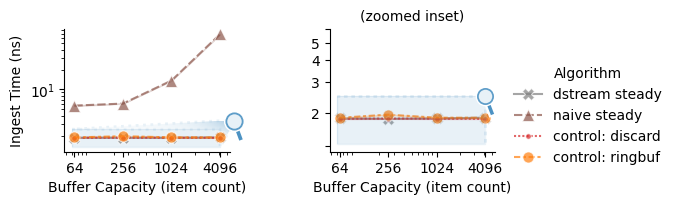

compiler='clang++', data_type='double word', num_items=10000, exclude=''


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4730/375946612.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


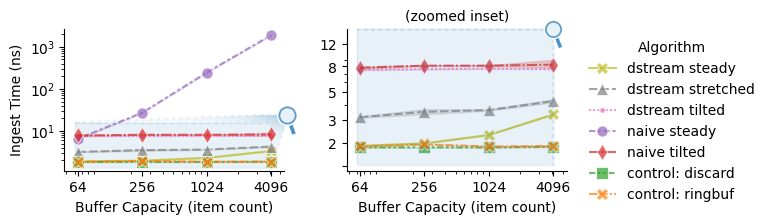

compiler='clang++', data_type='double word', num_items=10000, exclude='dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo'


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4730/375946612.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


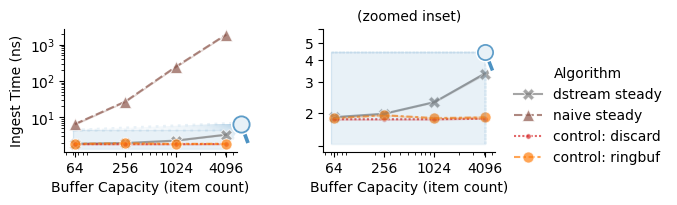

compiler='clang++', data_type='double word', num_items=1000000, exclude=''


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4730/375946612.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


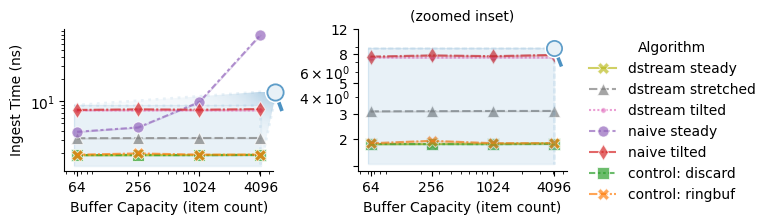

compiler='clang++', data_type='double word', num_items=1000000, exclude='dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo'


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4730/375946612.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


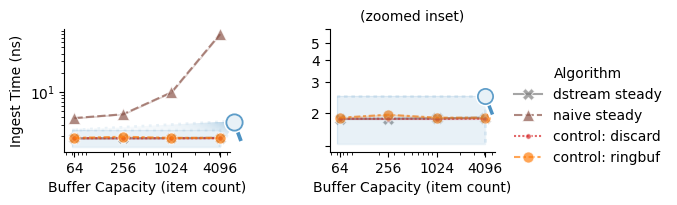

compiler='clang++', data_type='word', num_items=10000, exclude=''


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4730/375946612.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


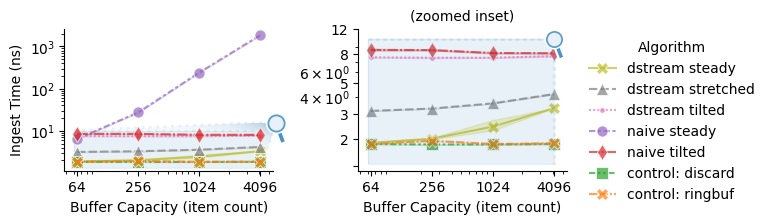

compiler='clang++', data_type='word', num_items=10000, exclude='dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo'


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4730/375946612.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


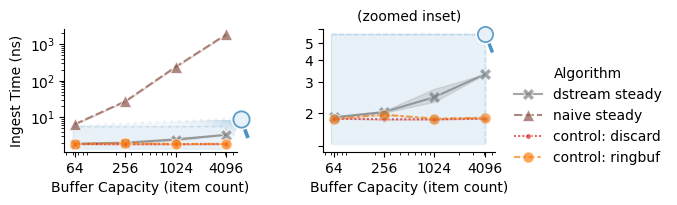

compiler='clang++', data_type='word', num_items=1000000, exclude=''


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4730/375946612.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


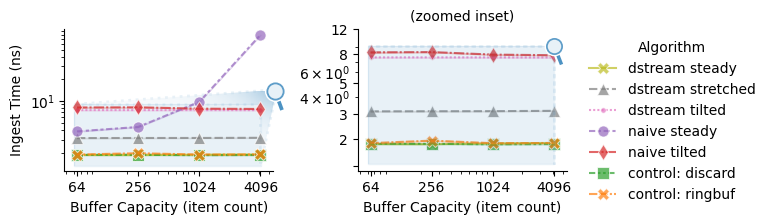

compiler='clang++', data_type='word', num_items=1000000, exclude='dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo'


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4730/375946612.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png, overwriting it
  warnings.warn(


teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


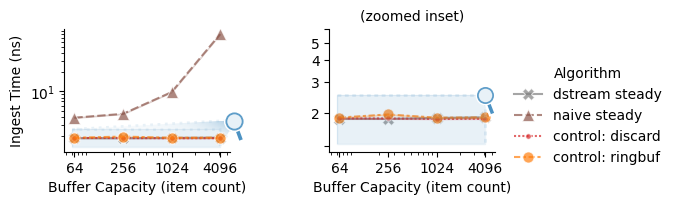

In [9]:
for compiler, data_type, num_items, exclude in it.product(
    df["compiler"].unique(),
    df["data type"].unique(),
    [10_000, 1_000_000],
    ["", "dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo"],
):
    print(f"{compiler=}, {data_type=}, {num_items=}, {exclude=}")
    data = (
        df.with_columns(
            is_naive=pl.col("algo_name") == "naive_steady_algo",
        )
        .filter(pl.col("num_items") == num_items)
        .filter(~pl.col("algo_name").is_in(exclude.split(",")))
        .filter(pl.col("compiler") == compiler)
        .filter(pl.col("data type") == data_type)
        .sort(
            "algorithm",
        )
        .to_pandas()
        .astype(
            {"algorithm": "category"},
        )
    )
    with tp.teed(
        otst.OutsetGrid,
        data=data,
        x="num_sites",
        y="duration_per_item_ns",
        row="is_naive",
        row_order=[False],
        marqueeplot_kws=dict(
            frame_outer_pad=(4.0, 0.2),
            frame_inner_pad=(4.0, 0.5),
            leader_stretch=0.8,
            frame_edge_kws={"alpha": 0.1},
            leader_edge_kws={"alpha": 0.1},
        ),
        height=2.2 if exclude else 2.5,
        aspect=1.2,
        palette="tab10_r",
        teeplot_subdir=teeplot_subdir,
        teeplot_outattrs=dict(
            compiler=compiler.replace("+", "x"),
            exclude=exclude,
            num_items=num_items
        ),
    ) as g:
        g.map_dataframe(
            sns.lineplot,
            x="num_sites",
            y="duration_per_item_ns",
            alpha=0.7,
            hue="algorithm",
            style="algorithm",
            style_order=sorted(data["algorithm"].unique()),
            markers=["X", "^", ".", "o", "d", "s"],
            ms=8,
            palette="tab10_r",
            zorder=otst.util.SplitKwarg(None, -1),
        )
        g.set(xlim=(32 * 1.5, 8192 / 1.5), xscale="log", yscale="log")
        g.marqueeplot(equalize_aspect=False)
        g.set(xlim=(32 * 1.5, 8192 / 1.5), xscale="log", yscale="log")
        g.set_xlabels("Buffer Capacity (item count)")
        g.set_ylabels("Ingest Time (ns)")
        yticks = [1.3, 2, 3, 5, 8, 12]
        ytick_labels = [" ", "2", "3", "5", "8", "12"]
        g.tight_layout()
        g.add_legend(title="Algorithm", bbox_to_anchor=(1.02, 0.45))
        ax = g.axes.flat[1]
        ax.set_ylim(1.2, None)
        ax.set_title("(zoomed inset)", size=10)
        labels = [item.get_text() for item in ax.get_xticklabels()]
        empty_string_labels = [""] * len(labels)
        ax.set_xticklabels(empty_string_labels)
        if exclude:
            yticks = [1.3, 2, 3, 4, 5, 6]
            ytick_labels = ["", "2", "3", "4", "5", " "]
        ax.yaxis.set_major_locator(mpl_ticker.FixedLocator(yticks))
        ax.set_yticks(yticks)
        ax.set_yticklabels(ytick_labels)
        g.set(
            xticks=[64, 256, 1024, 4096],
            xticklabels=["64", "256", "1024", "4096"],
        )


compiler='g++', data_type='word', exclude=''


/tmp/ipykernel_4730/3849207040.py:92: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)


teeplots/2025-01-18-cpp-bench-speed/color=black+compiler=gxx+data_type=word+exclude=+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/color=black+compiler=gxx+data_type=word+exclude=+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


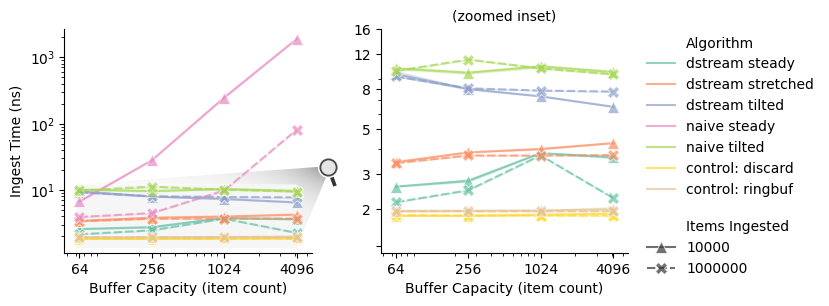

compiler='g++', data_type='word', exclude='dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo'


/tmp/ipykernel_4730/3849207040.py:92: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)


teeplots/2025-01-18-cpp-bench-speed/color=black+compiler=gxx+data_type=word+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/color=black+compiler=gxx+data_type=word+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


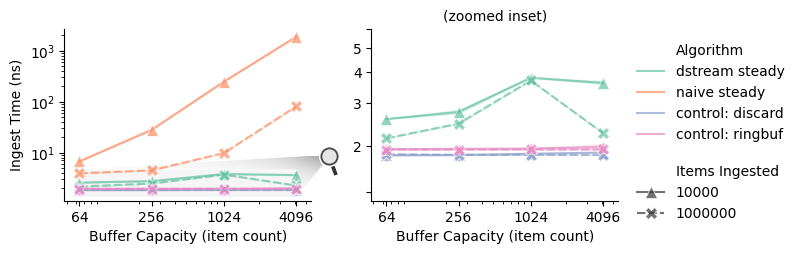

compiler='g++', data_type='bit', exclude=''


/tmp/ipykernel_4730/3849207040.py:92: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)


teeplots/2025-01-18-cpp-bench-speed/color=black+compiler=gxx+data_type=bit+exclude=+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/color=black+compiler=gxx+data_type=bit+exclude=+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


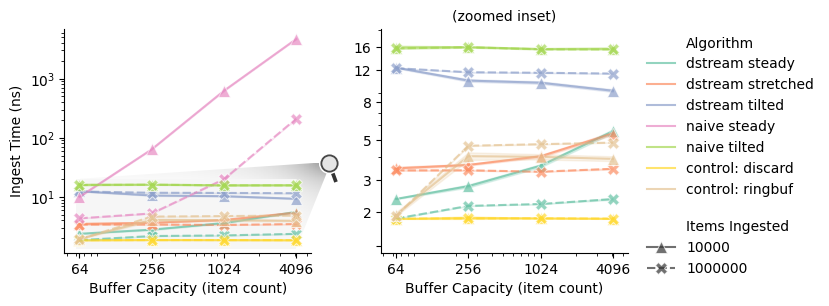

compiler='g++', data_type='bit', exclude='dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo'


/tmp/ipykernel_4730/3849207040.py:92: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)


teeplots/2025-01-18-cpp-bench-speed/color=black+compiler=gxx+data_type=bit+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/color=black+compiler=gxx+data_type=bit+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


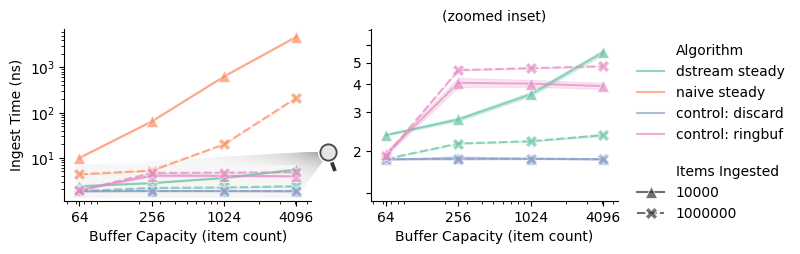

compiler='g++', data_type='double word', exclude=''


/tmp/ipykernel_4730/3849207040.py:92: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)


teeplots/2025-01-18-cpp-bench-speed/color=black+compiler=gxx+data_type=double word+exclude=+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/color=black+compiler=gxx+data_type=double word+exclude=+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


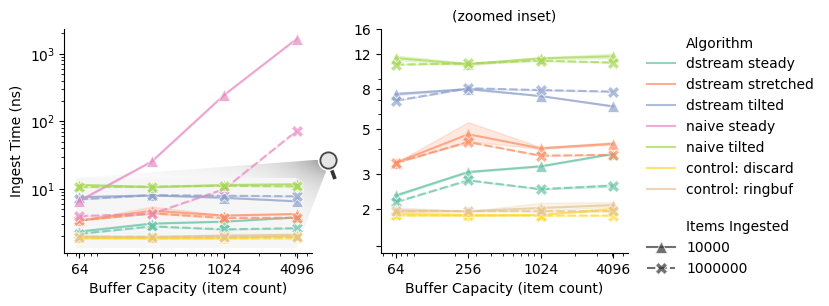

compiler='g++', data_type='double word', exclude='dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo'


/tmp/ipykernel_4730/3849207040.py:92: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)


teeplots/2025-01-18-cpp-bench-speed/color=black+compiler=gxx+data_type=double word+exclude=dstream.stretched_algo,dstream.tilted_algo,zh.../ao_tilted_algo+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/color=black+compiler=gxx+data_type=double word+exclude=dstream.stretched_algo,dstream.tilted_algo,zh.../ao_tilted_algo+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


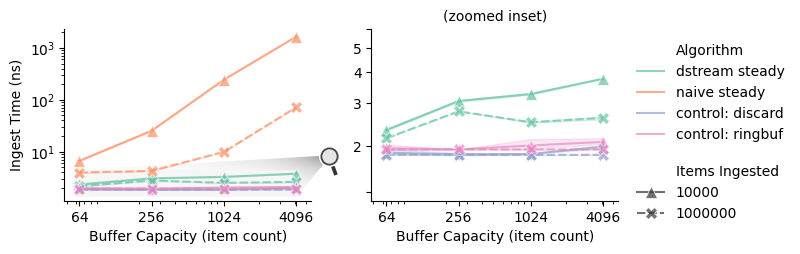

compiler='g++', data_type='byte', exclude=''


/tmp/ipykernel_4730/3849207040.py:92: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)


teeplots/2025-01-18-cpp-bench-speed/color=black+compiler=gxx+data_type=byte+exclude=+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/color=black+compiler=gxx+data_type=byte+exclude=+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


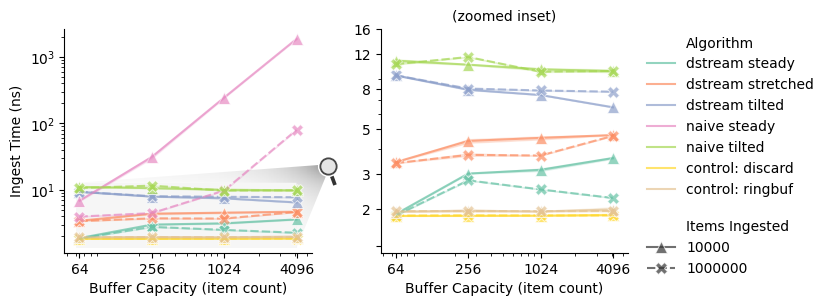

compiler='g++', data_type='byte', exclude='dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo'


/tmp/ipykernel_4730/3849207040.py:92: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)


teeplots/2025-01-18-cpp-bench-speed/color=black+compiler=gxx+data_type=byte+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/color=black+compiler=gxx+data_type=byte+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


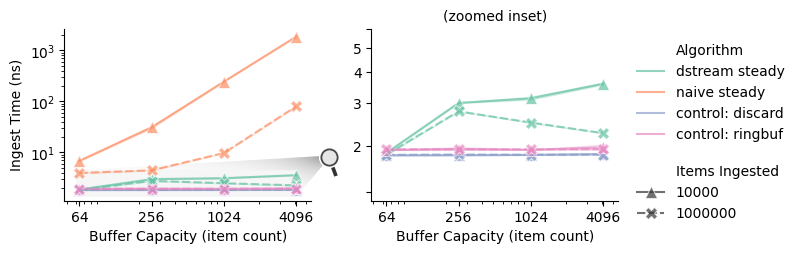

compiler='g++', data_type='quad word', exclude=''


/tmp/ipykernel_4730/3849207040.py:92: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)


teeplots/2025-01-18-cpp-bench-speed/color=black+compiler=gxx+data_type=quad word+exclude=+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/color=black+compiler=gxx+data_type=quad word+exclude=+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


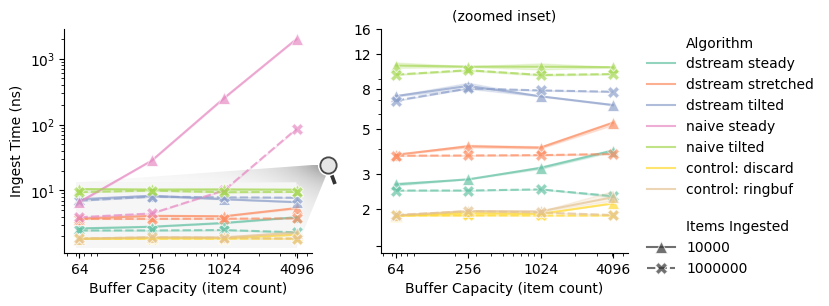

compiler='g++', data_type='quad word', exclude='dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo'


/tmp/ipykernel_4730/3849207040.py:92: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)


teeplots/2025-01-18-cpp-bench-speed/color=black+compiler=gxx+data_type=quad word+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/color=black+compiler=gxx+data_type=quad word+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


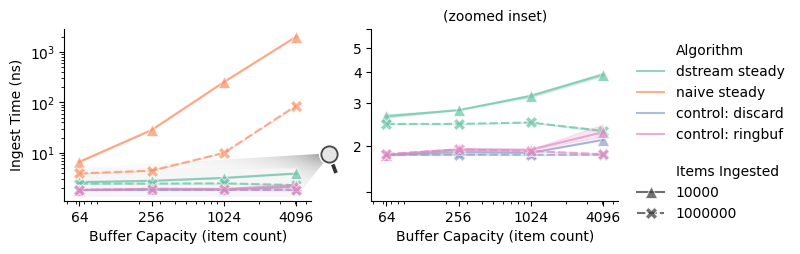

compiler='clang++', data_type='word', exclude=''


/tmp/ipykernel_4730/3849207040.py:92: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)


teeplots/2025-01-18-cpp-bench-speed/color=black+compiler=clangxx+data_type=word+exclude=+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/color=black+compiler=clangxx+data_type=word+exclude=+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


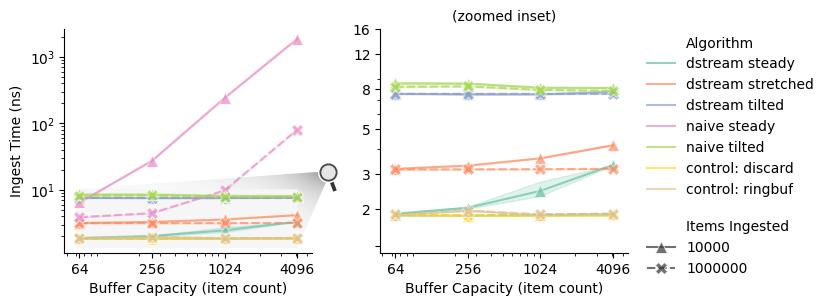

compiler='clang++', data_type='word', exclude='dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo'


/tmp/ipykernel_4730/3849207040.py:92: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)


teeplots/2025-01-18-cpp-bench-speed/color=black+compiler=clangxx+data_type=word+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/color=black+compiler=clangxx+data_type=word+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


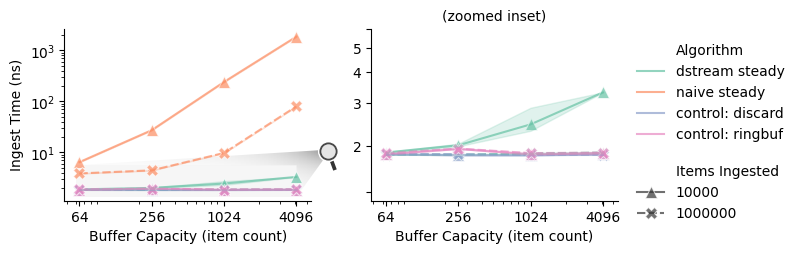

compiler='clang++', data_type='bit', exclude=''


/tmp/ipykernel_4730/3849207040.py:92: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)


teeplots/2025-01-18-cpp-bench-speed/color=black+compiler=clangxx+data_type=bit+exclude=+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/color=black+compiler=clangxx+data_type=bit+exclude=+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


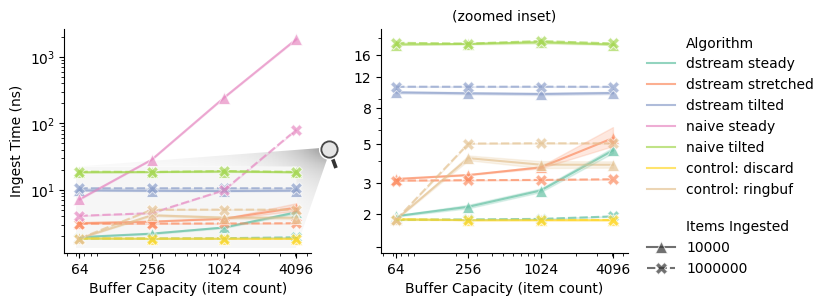

compiler='clang++', data_type='bit', exclude='dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo'


/tmp/ipykernel_4730/3849207040.py:92: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)


teeplots/2025-01-18-cpp-bench-speed/color=black+compiler=clangxx+data_type=bit+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/color=black+compiler=clangxx+data_type=bit+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


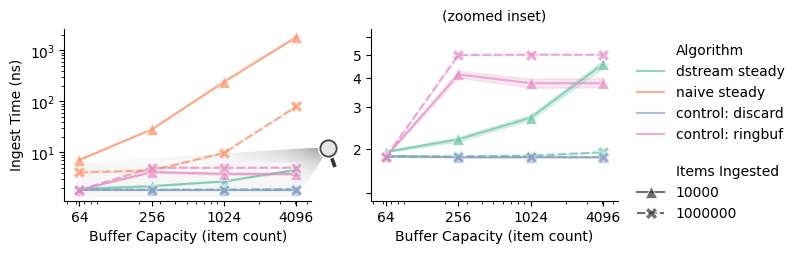

compiler='clang++', data_type='double word', exclude=''


/tmp/ipykernel_4730/3849207040.py:92: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)


teeplots/2025-01-18-cpp-bench-speed/color=black+compiler=clangxx+data_type=double word+exclude=+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/color=black+compiler=clangxx+data_type=double word+exclude=+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


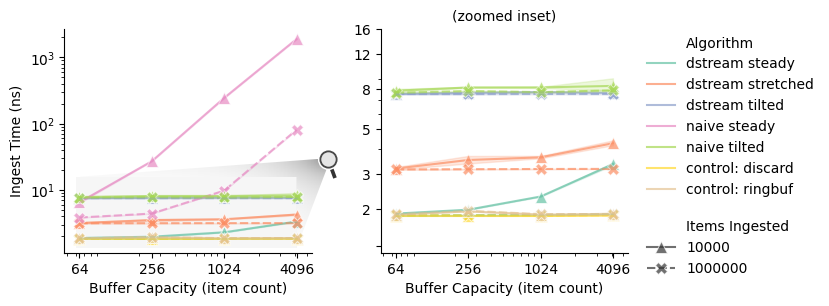

compiler='clang++', data_type='double word', exclude='dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo'


/tmp/ipykernel_4730/3849207040.py:92: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)


teeplots/2025-01-18-cpp-bench-speed/color=black+compiler=clangxx+data_type=double word+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ex.../t=.pdf
teeplots/2025-01-18-cpp-bench-speed/color=black+compiler=clangxx+data_type=double word+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ex.../t=.png


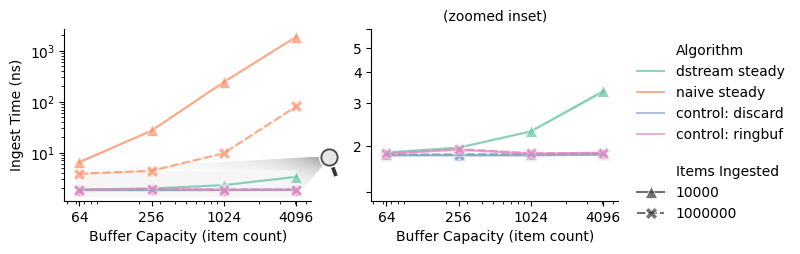

compiler='clang++', data_type='byte', exclude=''


/tmp/ipykernel_4730/3849207040.py:92: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)


teeplots/2025-01-18-cpp-bench-speed/color=black+compiler=clangxx+data_type=byte+exclude=+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/color=black+compiler=clangxx+data_type=byte+exclude=+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


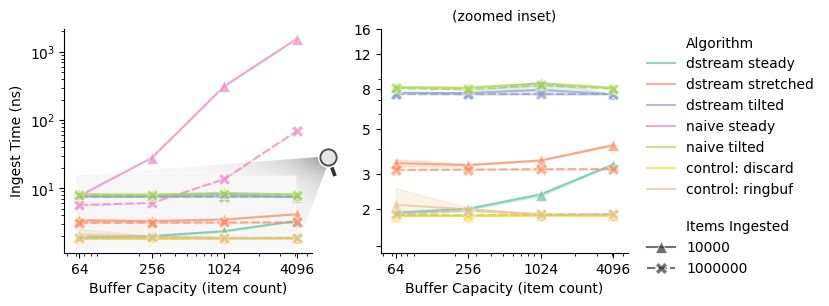

compiler='clang++', data_type='byte', exclude='dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo'


/tmp/ipykernel_4730/3849207040.py:92: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)


teeplots/2025-01-18-cpp-bench-speed/color=black+compiler=clangxx+data_type=byte+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/color=black+compiler=clangxx+data_type=byte+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


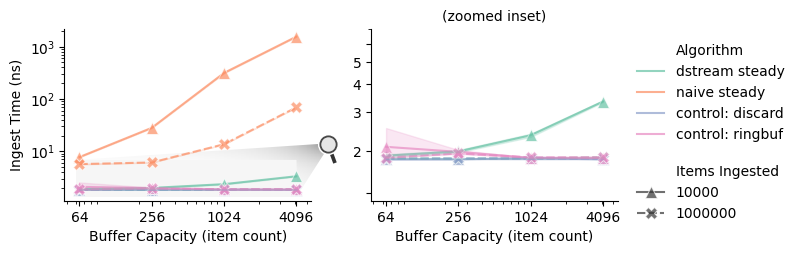

compiler='clang++', data_type='quad word', exclude=''


/tmp/ipykernel_4730/3849207040.py:92: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)


teeplots/2025-01-18-cpp-bench-speed/color=black+compiler=clangxx+data_type=quad word+exclude=+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/color=black+compiler=clangxx+data_type=quad word+exclude=+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


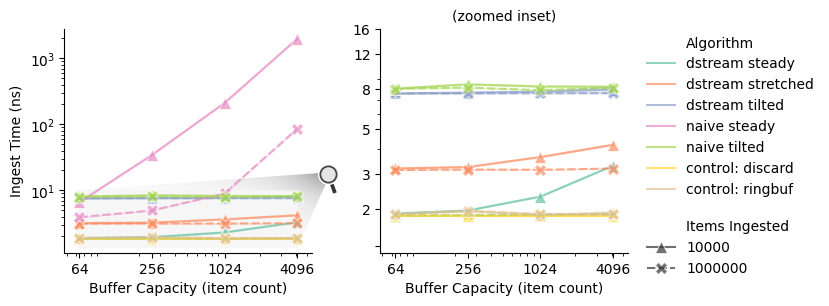

compiler='clang++', data_type='quad word', exclude='dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo'


/tmp/ipykernel_4730/3849207040.py:92: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)


teeplots/2025-01-18-cpp-bench-speed/color=black+compiler=clangxx+data_type=quad word+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.../.pdf
teeplots/2025-01-18-cpp-bench-speed/color=black+compiler=clangxx+data_type=quad word+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.../.png


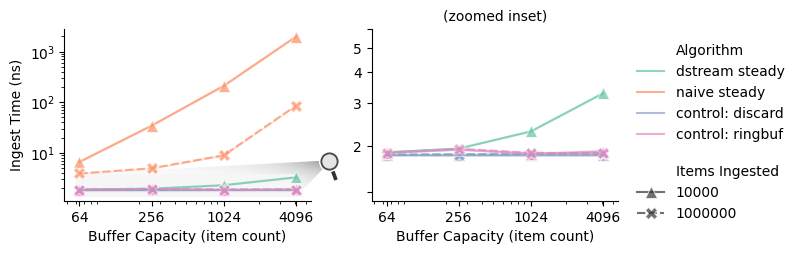

In [10]:
for compiler, data_type, exclude in it.product(
    df["compiler"].unique(),
    df["data type"].unique(),
    ("", "dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo"),
):
    print(f"{compiler=}, {data_type=}, {exclude=}")
    data = (
        df.with_columns(
            is_naive=pl.col("algo_name") == "naive_steady_algo",
        )
        .with_columns(
            pl.col("num_items").alias("\nItems Ingested"),
            pl.col("algorithm").alias("Algorithm"),
        )
        .filter(pl.col("num_items").is_in([10_000, 1_000_000]))
        .filter(~pl.col("algo_name").is_in(exclude.split(",")))
        .filter(pl.col("compiler") == compiler)
        .filter(pl.col("data type") == data_type)
        .sort(
            "algorithm",
        )
        .to_pandas()
        .astype(
            {"algorithm": "category"},
        )
    )
    with tp.teed(
        otst.OutsetGrid,
        data=data,
        color="black",
        x="num_sites",
        y="duration_per_item_ns",
        row="is_naive",
        row_order=[False],
        marqueeplot_kws=dict(
            # mark_glyph=otst.mark.MarkInlaidAsterisk(),
            frame_outer_pad=(4.0, 0.2),
            frame_inner_pad=(4.0, 0.5),
            leader_stretch=1.8,
        ),
        marqueeplot_source_kws=dict(
            leader_face_kws={"alpha": 0.5, "zorder": -2},
            frame_edge_kws={"alpha": 0.0},
            leader_edge_kws={"alpha": 0.0},
            frame_face_kws={"alpha": 0.07, "facecolor": "gray", "zorder": -2},
            zorder=100,
        ),
        marqueeplot_outset_kws=dict(
            frame_face_kws={"facecolor": "none"},
            frame_edge_kws={"alpha": 0.0},
            leader_edge_kws={"alpha": 0.0},
            mark_glyph=None,
        ),
        height=2.7 if exclude else 3.3,
        aspect=1.2 if exclude else 1,
        palette="tab10_r",
        teeplot_subdir=teeplot_subdir,
        teeplot_outattrs=dict(
            compiler=compiler.replace("+", "x"),
            data_type=data_type,
            exclude=exclude,
        ),
    ) as g:
        g.map_dataframe(
            sns.lineplot,
            x="num_sites",
            y="duration_per_item_ns",
            alpha=0.7,
            hue="Algorithm",
            style="\nItems Ingested",
            style_order=sorted(data["num_items"].unique()),
            markers=["^", "X"],
            ms=8,
            palette="Set2",
            zorder=otst.util.SplitKwarg(-1, -1),
        )
        g.set(xlim=(32 * 1.5, 8192 / 1.5), xscale="log", yscale="log")
        g.marqueeplot(
            equalize_aspect=False,
        )
        g.set(xlim=(32 * 1.5, 8192 / 1.5), xscale="log", yscale="log")
        g.set_xlabels("Buffer Capacity (item count)")
        g.set_ylabels("Ingest Time (ns)")
        yticks = [1.3, 2, 3, 5, 8, 12, 16]
        ytick_labels = [" ", "2", "3", "5", "8", "12", "16"]
        g.tight_layout()
        ax = g.axes.flat[1]
        ax.set_ylim(1.2, None)
        ax.set_title("(zoomed inset)", size=10)
        labels = [item.get_text() for item in ax.get_xticklabels()]
        empty_string_labels = [""] * len(labels)
        ax.set_xticklabels(empty_string_labels)
        if exclude:
            yticks = [1.3, 2, 3, 4, 5, 6]
            ytick_labels = ["", "2", "3", "4", "5", " "]
        ax.yaxis.set_major_locator(mpl_ticker.FixedLocator(yticks))
        ax.set_yticks(yticks)
        ax.set_yticklabels(ytick_labels)
        g.set(
            xticks=[64, 256, 1024, 4096],
            xticklabels=["64", "256", "1024", "4096"],
        )
        g.tight_layout()
        g.add_legend(bbox_to_anchor=(1.015, 0.47))


num_sites               algo_name compiler    data_type  speedup_mean  \
0           64       control_ring_algo  clang++          bit      2.199842   
1           64       control_ring_algo      g++  double word      2.035341   
2           64       control_ring_algo  clang++         word      2.064101   
3           64       control_ring_algo  clang++         byte      3.038108   
4           64       control_ring_algo      g++         word      2.025207   
5           64       control_ring_algo  clang++    quad word      2.078658   
6           64       control_ring_algo      g++         byte      2.037860   
7           64       control_ring_algo  clang++  double word      2.051972   
8           64       control_ring_algo      g++          bit      2.260678   
9           64       control_ring_algo      g++    quad word      2.107105   
10         256       control_ring_algo      g++         byte      2.296830   
11         256       control_ring_algo      g++         word      2.314393   
12         256       control_ring_algo  clang++          bit      0.889324   
13         256       control_ring_algo      g++          bit      1.129816   
14         256       control_ring_algo      g++    quad word      2.298377   
15         256       control_ring_algo  clang++         byte      3.130252   
16         256       control_ring_algo  clang++         word      2.276386   
17         256       control_ring_algo  clang++  double word      2.262111   
18         256       control_ring_algo      g++  double word      2.190124   
19         256       control_ring_algo  clang++    quad word      2.536384   
20        1024       control_ring_algo      g++  double word      5.102705   
21        1024       control_ring_algo  clang++         byte      7.277380   
22        1024       control_ring_algo      g++         byte      5.027615   
23        1024       control_ring_algo  clang++    quad word      4.751232   
24        1024       control_ring_algo      g++         word      5.063003   
25        1024       control_ring_algo  clang++          bit      1.959888   
26        1024       control_ring_algo      g++    quad word      5.240309   
27        1024       control_ring_algo  clang++         word      5.206013   
28        1024       control_ring_algo  clang++  double word      5.214873   
29        1024       control_ring_algo      g++          bit      4.207771   
30        4096       control_ring_algo      g++         word     41.439900   
31        4096       control_ring_algo      g++  double word     36.881284   
32        4096       control_ring_algo  clang++         byte     36.854078   
33        4096       control_ring_algo  clang++          bit     15.905928   
34        4096       control_ring_algo      g++         byte     40.914923   
35        4096       control_ring_algo  clang++    quad word     45.520510   
36        4096       control_ring_algo  clang++  double word     43.028001   
37        4096       control_ring_algo      g++          bit     43.670771   
38        4096       control_ring_algo      g++    quad word     46.152007   
39        4096       control_ring_algo  clang++         word     42.308907   
40          64  control_throwaway_algo      g++         word      2.115129   
41          64  control_throwaway_algo  clang++         byte      3.079013   
42          64  control_throwaway_algo      g++         byte      2.145795   
43          64  control_throwaway_algo  clang++          bit      2.199766   
44          64  control_throwaway_algo      g++          bit      2.340997   
45          64  control_throwaway_algo  clang++    quad word      2.115599   
46          64  control_throwaway_algo  clang++         word      2.084608   
47          64  control_throwaway_algo      g++    quad word      2.120467   
48          64  control_throwaway_algo  clang++  double word      2.077882   
49          64  control_throwaway_algo      g++  double word      2.138214   
50         256  control_thr

num_sites               algo_name compiler    data_type  speedup_mean  \
0           64       control_ring_algo      g++         word      3.455971   
1           64       control_ring_algo  clang++  double word      3.494644   
2           64       control_ring_algo      g++         byte      3.549905   
3           64       control_ring_algo      g++          bit      5.165413   
4           64       control_ring_algo      g++    quad word      3.615333   
5           64       control_ring_algo  clang++    quad word      3.525598   
6           64       control_ring_algo  clang++          bit      3.875081   
7           64       control_ring_algo  clang++         word      3.486726   
8           64       control_ring_algo      g++  double word      3.392319   
9           64       control_ring_algo  clang++         byte      3.996763   
10         256       control_ring_algo  clang++          bit      6.900058   
11         256       control_ring_algo      g++         word     14.388275   
12         256       control_ring_algo  clang++  double word     14.016831   
13         256       control_ring_algo  clang++    quad word     17.807097   
14         256       control_ring_algo      g++         byte     16.004731   
15         256       control_ring_algo      g++  double word     13.091349   
16         256       control_ring_algo      g++    quad word     14.621041   
17         256       control_ring_algo  clang++         byte     14.172388   
18         256       control_ring_algo  clang++         word     13.993255   
19         256       control_ring_algo      g++          bit     15.858316   
20        1024       control_ring_algo  clang++    quad word    113.206673   
21        1024       control_ring_algo      g++  double word    123.289718   
22        1024       control_ring_algo  clang++         word    129.916059   
23        1024       control_ring_algo  clang++  double word    130.827532   
24        1024       control_ring_algo  clang++         byte    168.482796   
25        1024       control_ring_algo  clang++          bit     64.614588   
26        1024       control_ring_algo      g++         byte    126.081352   
27        1024       control_ring_algo      g++         word    125.975589   
28        1024       control_ring_algo      g++    quad word    130.477376   
29        1024       control_ring_algo      g++          bit    156.155573   
30        4096       control_ring_algo  clang++  double word   1001.150448   
31        4096       control_ring_algo      g++          bit   1203.583252   
32        4096       control_ring_algo      g++         word    946.939009   
33        4096       control_ring_algo  clang++         byte    831.767693   
34        4096       control_ring_algo  clang++         word    991.353073   
35        4096       control_ring_algo      g++         byte    941.043736   
36        4096       control_ring_algo      g++  double word    797.290824   
37        4096       control_ring_algo  clang++          bit    491.132521   
38        4096       control_ring_algo  clang++    quad word   1041.233793   
39        4096       control_ring_algo      g++    quad word    887.400919   
40          64  control_throwaway_algo  clang++         word      3.487390   
41          64  control_throwaway_algo      g++         byte      3.727233   
42          64  control_throwaway_algo      g++         word      3.663156   
43          64  control_throwaway_algo      g++    quad word      3.625788   
44          64  control_throwaway_algo  clang++          bit      3.859399   
45          64  control_throwaway_algo      g++  double word      3.537638   
46          64  control_throwaway_algo  clang++         byte      4.216009   
47          64  control_throwaway_algo  clang++    quad word      3.608578   
48          64  control_throwaway_algo  clang++  double word      3.549280   
49          64  control_throwaway_algo      g++          bit      5.441261   
50         256  control_thr

teeplots/2025-01-18-cpp-bench-speed/col=compiler+hue=algo-name+kind=bar+viz=catplot+x=num-sites+y=speedup+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/col=compiler+hue=algo-name+kind=bar+viz=catplot+x=num-sites+y=speedup+ext=.png


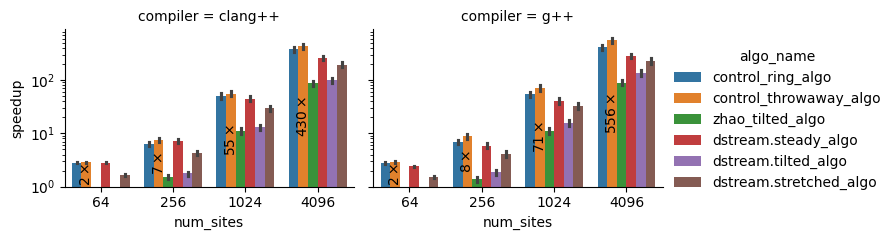

In [11]:
# 1) Compute mean duration per group x algo
df_agg = df.group_by(
    ["compiler", "data_type", "num_items", "num_sites", "replicate", "algo_name"]
).agg(mean_duration_s=pl.col("duration_s").mean())

# 2) Compute mean duration *just for* "naive_steady_algo"
df_naive = (
    df.filter(pl.col("algo_name") == "naive_steady_algo")
    .group_by(["compiler", "data_type", "num_items", "num_sites", "replicate"])
    .agg(naive_mean_duration_s=pl.col("duration_s").mean())
)

# 3) Join the two on compiler,num_items,num_sites,replicate
df_speedup = df_agg.join(
    df_naive,
    on=["compiler", "data_type", "num_items", "num_sites", "replicate"],
    how="left",
).with_columns(
    (pl.lit(1_000_000_000) * pl.col("mean_duration_s") / pl.col("num_items"))
    .alias("ns_per_op"),
    # 4) Speedup = ratio vs. naive_steady_algo
    (pl.col("naive_mean_duration_s") / pl.col("mean_duration_s")).alias(
        "speedup"
    )
)

# Display tabular results
with pd.option_context("display.max_columns", None):
    with pd.option_context("display.max_rows", None):
        display(
            df_speedup.filter(pl.col("num_items") == 1_000_000)
            .group_by(["num_sites", "algo_name", "compiler", "data_type"])
            .agg(
                speedup_mean=pl.col("speedup").mean(),
                speedup_std=pl.col("speedup").std(),
                ns_per_op_mean=pl.col("ns_per_op").mean(),
                ns_per_op_std=pl.col("ns_per_op").std(),
            )
            .sort(["algo_name", "num_sites"])
            .to_pandas()
        )

# Display tabular results
with pd.option_context("display.max_columns", None):
    with pd.option_context("display.max_rows", None):
        display(
            df_speedup.filter(pl.col("num_items") == 10_000)
            .group_by(["num_sites", "algo_name", "compiler", "data_type"])
            .agg(
                speedup_mean=pl.col("speedup").mean(),
                speedup_std=pl.col("speedup").std(),
                ns_per_op_mean=pl.col("ns_per_op").mean(),
                ns_per_op_std=pl.col("ns_per_op").std(),
            )
            .sort(["algo_name", "num_sites"])
            .to_pandas()
        )

# Now plot speedup on a log scale
with tp.teed(
    sns.catplot,
    data=df_speedup.cast({"num_sites": str}).filter(
        pl.col("algo_name") != "naive_steady_algo"
    ),
    x="num_sites",
    y="speedup",
    order=list(map(str, sorted(df_speedup["num_sites"].unique()))),
    hue="algo_name",
    col="compiler",
    kind="bar",
    aspect=1.4,
    height=2.5,
    teeplot_subdir=teeplot_subdir,
) as g:
    g.set(yscale="log", ylim=(1, None))
    for ax in g.axes.flat:
        ax.bar_label(
            ax.containers[1],
            fmt="$%d\\times$",
            label_type="center",
            rotation=90,
        )
